# Classification d'images médicales
## Le projet
Projet de MLOps
Machine learning end to end allant du dataset ( interpretation, pre processing, analyse) en passant par le développement jusqu'au déployement avec une notion d'explicabilité nécessaire dans notre cas d'étude à savoir l'imagerie médicale.
Notre dataset est composé d'images médicales cérébrales à classifier grâce au machine learning. Deux algorithmes basés sur la méthode transformer sont proposés : transformer + heatmap ou transformer + attention rollout. 
## Qu'est ce que transformers? 
Les algorithmes de Transformer avec déploiement d'attention ou cartes thermiques sont des techniques pour visualiser et comprendre comment un modèle de vision Transformer fait des prédictions. Ils peuvent être utiles pour améliorer la transparence et la compréhension des modèles de vision, ce qui peut être important dans des domaines tels que la médecine où les décisions du modèle peuvent avoir des conséquences importantes pour les patients.

Les algorithmes de Transformer avec déploiement d'attention permettent de visualiser les régions de l'image qui ont été les plus influentes pour une prédiction donnée. Cela peut aider à comprendre comment le modèle interagit avec les différentes parties de l'image pour faire des prédictions. Les algorithmes de cartes thermiques fonctionnent de manière similaire, en utilisant une représentation visuelle pour montrer les régions de l'image qui ont été les plus importantes pour une prédiction.

Dans le cas d'un projet de classification de tumeurs cérébrales à l'aide d'un modèle de Vision Transformer, ces algorithmes pourraient être utiles pour comprendre comment le modèle fait des prédictions pour différents types de tumeurs et comment il utilise les informations de l'image pour faire des prédictions. Cela peut aider à identifier des domaines où le modèle peut être amélioré ou des sources potentielles de biais, ce qui peut améliorer la qualité et la fiabilité des résultats.



##Programmation


####Chargement du dataset
https://www.tensorflow.org/tutorials/load_data/images?hl=fr

In [1]:
#Librairies
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import pathlib
import keras

In [2]:
#Connexion au dossier drive contenant les images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Chemin vers le dataset préalablement chargé dans le drive
data_dir="/content/drive/MyDrive/Projet_IA_Imagerie/dataset/"
dir_train= "/content/drive/MyDrive/Projet_IA_Imagerie/dataset/Training/"
dir_test = "/content/drive/MyDrive/Projet_IA_Imagerie/dataset/Testing/"

data_dir=pathlib.Path(data_dir)
dir_train= pathlib.Path(dir_train)
dir_test = pathlib.Path(dir_test)

In [4]:
#On importe deux des classes dans des listes : glioma_tumor et no_tumor cad prb vs pas de prb
glioma_tumor_train = list(dir_train.glob('glioma_tumor/*'))
glioma_tumor_test = list(dir_test.glob('glioma_tumor/*'))
no_tumor_train = list(dir_train.glob('glioma_tumor/*'))
no_tumor_test = list(dir_test.glob('glioma_tumor/*'))
#PIL.Image.open(str(glioma_tumor_train[0]))


 Standardisation des données:

 Les valeurs des canaux RVB sont dans la plage [0, 255] . Ce n'est pas idéal pour un réseau neuronal ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites.

Ici, vous allez normaliser les valeurs pour qu'elles soient dans la plage [0, 1] en utilisant tf.keras.layers.Rescaling :

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
#A METTRE DANS LE MODEL VIT !!!!!

#Model VIT

#### Transformers vision rollout
https://keras.io/examples/vision/probing_vits/

In [6]:
#ViT = vision Transformer
!pip install -U gdown -q.



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -.


In [7]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [8]:
RESOLUTION = 224
PATCH_SIZE = 16

####Preprocess

In [9]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = normalization_layer
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


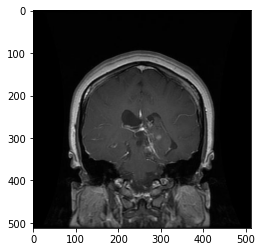

In [10]:
pic=PIL.Image.open(str(glioma_tumor_train[0]))
plt.imshow(pic)

In [11]:
preprocessed_image = preprocess_image(pic, "original_vit")

####Get model

In [12]:

def get_model(model_name: str) -> tf.keras.Model:
   # inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
   # outputs = model(inputs)
    #print(outputs.shape)
    return model

vit_base_i21k_patch16_224 = get_model("/content/vit_b16_patch16_224")
print(vit_base_i21k_patch16_224.summary())
print("Model loaded.")



Model: "vi_t_classifier_extended"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (None, 196, 768)          590592    
                                                                 
 transformer_block_0 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_1 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_2 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_3 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, N

In [13]:
#vit_base_i21k_patch16_224 = get_model('1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ')
#print("Model loaded.")

In [14]:
attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)

1/1 [==============================] - 2s 2s/step


In [15]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)

1/1 [==============================] - 1s 727ms/step


In [16]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result



Test avec leur image

In [17]:
crop_layer_2 = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer_2 = keras.layers.Normalization(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],)
rescale_layer_2 = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image2 = preprocess_image(image, model_type)
    return image, preprocessed_image2

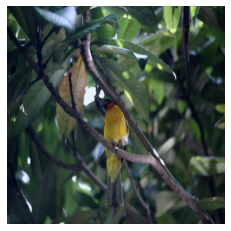

In [18]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image2 = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()


In [19]:
predictions2, attention_score_dict2 = vit_base_i21k_patch16_224.predict(
    preprocessed_image2
)
#attn_rollout_result = attention_rollout_map(image, attention_score_dict, model_type="original_vit")

1/1 [==============================] - 1s 718ms/step


In [20]:
attn_rollout_result2 = attention_rollout_map(
    image, attention_score_dict2, model_type="original_vit"
)

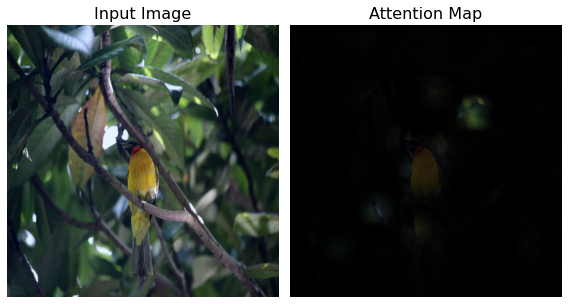

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result2)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()


Test avec notre image

In [22]:
attn_rollout_result = attention_rollout_map(
    pic, attention_score_dict, model_type="original_vit"
)

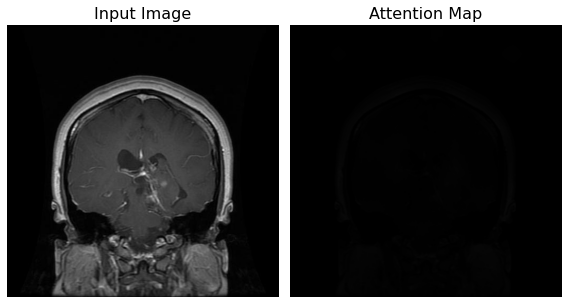

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))

_ = ax1.imshow(pic)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()


###Transformer heatmap

#Classification

In [24]:
len(glioma_tumor_train)

836

In [25]:
train_images=glioma_tumor_train+no_tumor_train
labels_tumor=['tumor' for i in range(836)]
labels_no_tumor=['no tumor'for i in range(836)]
labels=labels_tumor+labels_no_tumor


In [26]:
vit_base_i21k_patch16_224.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




In [27]:
l=[]
for i in train_images :
  l.append(PIL.Image.open(i)) 



In [28]:
l_array=np.array(train_images)
labels=np.array(labels)


In [29]:
l_array=np.asarray(l)
train_images_array=np.asarray(train_images)

<ipython-input-29-ea544328a595>:1: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  l_array=np.asarray(l)
<ipython-input-29-ea544328a595>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  l_array=np.asarray(l)


In [30]:
data_ds = keras.utils.image_dataset_from_directory(data_dir, batch_size=64, image_size=(224, 224))#training and testing
train_ds = keras.utils.image_dataset_from_directory(dir_train, batch_size=64, image_size=(224, 224))
test_ds = keras.utils.image_dataset_from_directory(dir_test, batch_size=64, image_size=(224, 224))
class_names = train_ds.class_names
print(class_names)

Found 3274 files belonging to 2 classes.
Found 2880 files belonging to 4 classes.
Found 394 files belonging to 4 classes.
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
vit_base_i21k_patch16_224.fit(train_ds)

In [ ]:
glioma_tumor_train = list(dir_train.glob('glioma_tumor/*'))
glioma_tumor_test = list(dir_test.glob('glioma_tumor/*'))
no_tumor_train = list(dir_train.glob('glioma_tumor/*'))
no_tumor_test = list(dir_test.glob('glioma_tumor/*'))

In [ ]:
glioma_tumor_train_vit = vit(glioma_tumor_train)
glioma_tumor_test_vit = vit(glioma_tumor_test)
no_tumor_train_vit = vit(no_tumor_train)
no_tumor_test_vit = vit(no_tumor_test)

In [ ]:
def vit(images):
  images_vit=[]
  for i in images:
    image=PIL.Image.open(str(i))
    preprocessed_image = preprocess_image(image, "original_vit")
    predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(preprocessed_image)
    attn_rollout_result = attention_rollout_map(pic, attention_score_dict, model_type="original_vit")
    images_vit.append(attn_rollout_result)